# KNN 기초 (회귀)

- KNN 알고리즘으로 모델링하기
- 스케일링

0. 라이브러리 불러오기 및 데이터 불러오기
1. 데이터 파악하기
2. 데이터 준비하기
3. 모델링
4. 시각화

# 0. 라이브러리 불러오기 및 데이터 불러오기

In [36]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

# 데이터 읽어오기
path = './data/airquilty.csv'
data = pd.read_csv(path)

# 1. 데이터 파악하기

In [37]:
# 상위 몇 개 행 확인
data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41,190.0,7.4,67,5,1
1,36,118.0,8.0,72,5,2
2,12,149.0,12.6,74,5,3
3,18,313.0,11.5,62,5,4
4,19,NaN,14.3,56,5,5


In [38]:
# 기술통계 확인
data.describe()

,Ozone,Solar.R,Wind,Temp,Month,Day
count,153.000000,146.000000,153.000000,153.000000,153.000000,153.000000
mean,42.052288,185.931507,9.957516,77.882353,6.993464,15.803922
std,30.156127,90.058422,3.523001,9.465270,1.416522,8.864520
min,1.000000,7.000000,1.700000,56.000000,5.000000,1.000000
25%,20.000000,115.750000,7.400000,72.000000,6.000000,8.000000
50%,34.000000,205.000000,9.700000,79.000000,7.000000,16.000000
75%,59.000000,258.750000,11.500000,85.000000,8.000000,23.000000
max,168.000000,334.000000,20.700000,97.000000,9.000000,31.000000


In [39]:
# NaN 값 확인
data.isnull().sum()

Ozone      0
Solar.R    7
Wind       0
Temp       0
Month      0
Day        0
dtype: int64

In [40]:
# 상관관계 확인
data.corr()

,Ozone,Solar.R,Wind,Temp,Month,Day
Ozone,1.000000,0.280068,-0.605478,0.683372,0.174197,0.004419
Solar.R,0.280068,1.000000,-0.056792,0.275840,-0.075301,-0.150275
Wind,-0.605478,-0.056792,1.000000,-0.457988,-0.178293,0.027181
Temp,0.683372,0.275840,-0.457988,1.000000,0.420947,-0.130593
Month,0.174197,-0.075301,-0.178293,0.420947,1.000000,-0.007962
Day,0.004419,-0.150275,0.027181,-0.130593,-0.007962,1.000000


# 2. 데이터 준비하기

**1) 결측치 처리**

- 결측치가 있으면 제거하거나 적절한 값으로 채웁니다.
- 시계열 데이터이므로 선형보간법으로 채웁니다.

In [41]:
# 결측치 확인
data.isnull().sum()

Ozone      0
Solar.R    7
Wind       0
Temp       0
Month      0
Day        0
dtype: int64

In [42]:
# 결측치 채우기
data.interpolate(method='linear', inplace=True)

# 확인
data.isnull().sum()

Ozone      0
Solar.R    0
Wind       0
Temp       0
Month      0
Day        0
dtype: int64

**2) 변수 제거**

- 분석에 의미가 없다고 판단되는 변수는 제거합니다.
- Month, Day 열을 제거합니다.

In [43]:
#  변수 제거
drop_cols = ['Month', 'Day']
data.drop(drop_cols, axis=1, inplace=True)

# 확인
data.head()

,Ozone,Solar.R,Wind,Temp
0,41,190.000000,7.4,67
1,36,118.000000,8.0,72
2,12,149.000000,12.6,74
3,18,313.000000,11.5,62
4,19,308.333333,14.3,56


**3) x, y 분리**

- target 변수를 명확히 지정합니다.
- target을 제외한 변수를 x 데이터프레임으로 선언합니다.
- y 데이터프레임은 target 변수만을 가집니다.

In [44]:
# target 확인
target = 'Ozone'

# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

**4) 학습용, 평가용 데이터 분리**

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.
- 반복 실행 시 동일한 결과를 얻기 위해 random_state 옵션을 지정합니다.

In [45]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

**4) 정규화**

- KNN 알고리즘을 사용하기 위해 정규화를 진행합니다.
- 다음 중 한 가지 방법을 사용해 진행합니다.

- 방법1: 공식 사용

$$ \large x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$


In [24]:
# 최대값, 최솟값 구하기
x_max = x_train.max()
x_min = x_train.min()

# 정규화
x_train = (x_train - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)

# 확인
x_train.head()

,Solar.R,Wind,Temp
132,0.770642,0.421053,0.447368
73,0.513761,0.694737,0.657895
18,0.963303,0.515789,0.315789
48,0.091743,0.394737,0.236842
4,0.921509,0.663158,0.000000


- 방법 2: 함수 사용

In [49]:
# 모듈(=함수) 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
scaler = MinMaxScaler()
scaler.fit(x_train) # 최대-최솟값 찾기
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# 확인하기
x_train[:10] # 결과는 배열

array([[0.7706422 , 0.42105263, 0.44736842],
       [0.51376147, 0.69473684, 0.65789474],
       [0.96330275, 0.51578947, 0.31578947],
       [0.09174312, 0.39473684, 0.23684211],
       [0.92150866, 0.66315789, 0.        ],
       [0.96330275, 0.51578947, 0.60526316],
       [0.12538226, 0.66315789, 0.63157895],
       [0.86850153, 0.63684211, 0.89473684],
       [0.78593272, 0.66315789, 0.60526316],
       [0.44648318, 0.21052632, 0.84210526]])

- 방법 2 간결하게 쓰기

In [54]:
# 모듈(=함수) 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# 확인하기
x_train[:10]

array([[0.7706422 , 0.42105263, 0.44736842],
       [0.51376147, 0.69473684, 0.65789474],
       [0.96330275, 0.51578947, 0.31578947],
       [0.09174312, 0.39473684, 0.23684211],
       [0.92150866, 0.66315789, 0.        ],
       [0.96330275, 0.51578947, 0.60526316],
       [0.12538226, 0.66315789, 0.63157895],
       [0.86850153, 0.63684211, 0.89473684],
       [0.78593272, 0.66315789, 0.60526316],
       [0.44648318, 0.21052632, 0.84210526]])

# 3.모델링

- 본격적으로 모델을 선언하고 학습하고 평가하는 과정을 진행합니다.

In [25]:
# 1단계: 불러오기
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [26]:
# 2단계: 선언하기
model = KNeighborsRegressor()

In [27]:
# 3단계: 학습하기
model.fit(x_train, y_train)

KNeighborsRegressor()

In [28]:
# 4단계 예측하기
y_pred = model.predict(x_test)

print(y_pred[:10]) # 예측값 10개 보기
print(y_test.values[:10]) # 실제값 10개 보기

[18.6 16.4 87.4 47.  37.6 20.  84.  14.6 39.8 28. ]
[24 18 97 47 34 22 66 18 69 27]


In [30]:
# 5단계: 평가하기
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test,y_pred))

12.443478260869565
0.6168024614834005


# 4. 시각화

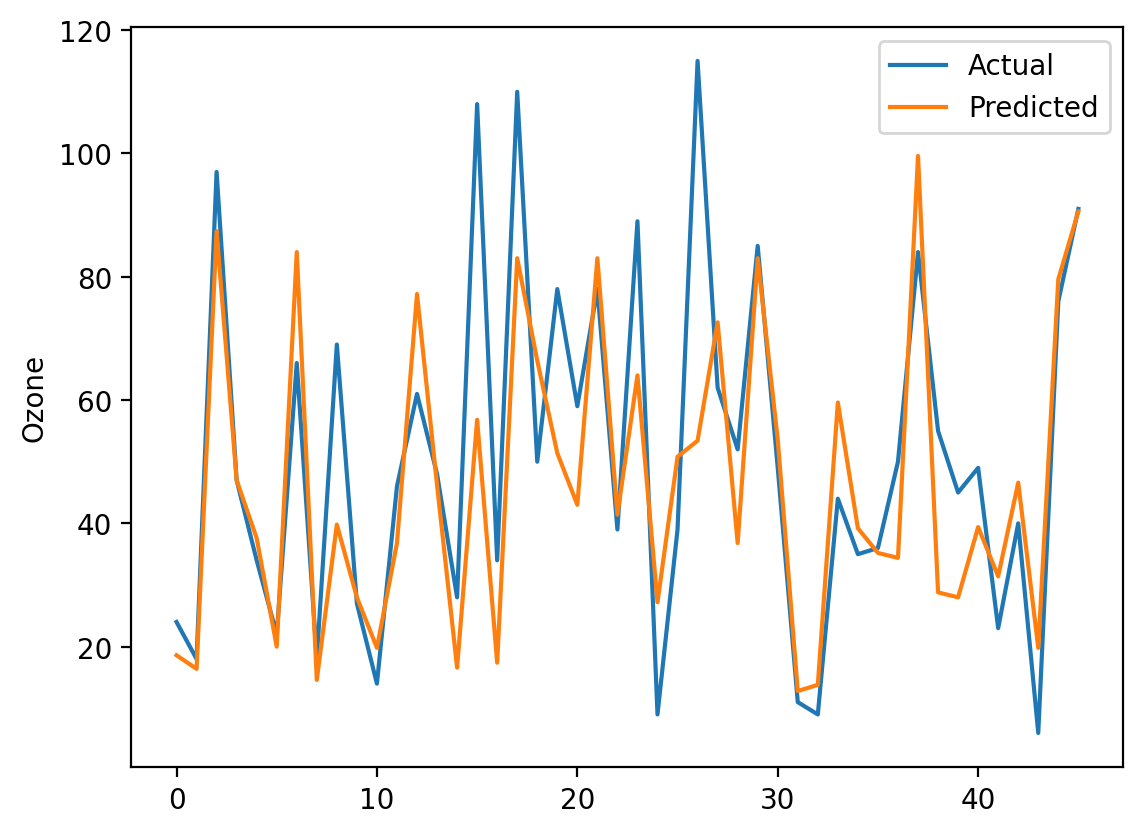

In [55]:
# 예측값, 실젯값 시각화
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.ylabel('Ozone')
plt.show()